In [1]:
import torchxrayvision as xrv
import skimage, torch, torchvision
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.models import resnet18
from torchvision.transforms.functional import normalize, resize, to_pil_image
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask
from matplotlib import cm
import os
# from skimage.filters import threshold_otsu
import cv2


## Define the Labels and tools

In [2]:
def map_predictions(predictions):
    labels = [
        'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
        'Emphysema', 'Enlarged Cardiomediastinum', 'Fibrosis', 'Fracture', 'Hernia',
        'Infiltration', 'Lung Lesion', 'Lung Opacity', 'Mass', 'Nodule',
        'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
    ]

    return  list(zip(labels, predictions))

In [3]:
def grey2rgb(image):
    return np.stack([image, image, image], axis=2)

In [4]:
def otsu_process(cam):
    # Normalize the Grad-CAM matrix between 0 and 255, and convert it to an 8-bit grayscale image
    cam_numpy = cam
    cam_otsu = ((cam_numpy - cam_numpy.min()) / (cam_numpy.max() - cam_numpy.min()) * 255).astype(np.uint8)

    # Apply Otsu's thresholding method to find the optimal threshold
    _, threshold = cv2.threshold(cam_otsu, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Set all values below the threshold to 0 in the original Grad-CAM matrix (normalized to [0, 1])
    cam_otsu = np.where(cam_numpy < threshold, cam_numpy / 255.0, 0)
    # Set all values bigger than 0 to 1
    cam_otsu = np.where(cam_otsu > 0, 1, 0)
    # #convert into tensor
    # cam_otsu = torch.from_numpy(cam_otsu).float()
    cam_otsu = cam_otsu.astype(np.float32)
    return cam_otsu

In [5]:
def overlay_dashed_border_on_image(image, mask, color=(255, 0, 0), dash_length=5):

    def draw_dashed_contour(img, contour, color, dash_length):
        # Draw a dashed line along the contour
        for i in range(0, len(contour), dash_length * 2):
            cv2.polylines(img, [contour[i:i + dash_length]], isClosed=False, color=color, thickness=2)

    # Create a copy of the original image
    image_with_border = image.copy()

    # Find the contour of the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw dashed lines along the contour
    for contour in contours:
        draw_dashed_contour(image_with_border, contour, color, dash_length)

    return image_with_border

In [6]:
def overlay_mask_on_image(image, mask, color=(255, 0, 0), alpha=0.5):
 
    # copy the image
    image = image.copy()
    # Create a 3-channel colored version of the mask
    colored_mask = grey2rgb(mask)
    colored_mask[mask == 1] = color
    # Convert the original image to float
    image_float = image.astype(np.float32)

    # Overlay the colored mask on the original image with the given alpha value
    overlayed_image = cv2.addWeighted(colored_mask, alpha, image_float, 1 - alpha, 0)
    
    

    # Convert the result back to uint8
    overlayed_image = overlayed_image.astype(np.uint8)
    
    

    return overlayed_image

In [7]:
labels = [
        'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
        'Emphysema', 'Enlarged Cardiomediastinum', 'Fibrosis', 'Fracture', 'Hernia',
        'Infiltration', 'Lung Lesion', 'Lung Opacity', 'Mass', 'Nodule',
        'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
    ]

In [8]:
model = xrv.models.DenseNet(weights="densenet121-res224-all")
model.eval()


XRV-DenseNet121-densenet121-res224-all

Original image size: (1024, 1024)
Setting XRayResizer engine to cv2 could increase performance.
Model input size: torch.Size([1, 224, 224])
[('Atelectasis', 0.24613942), ('Cardiomegaly', 0.03629454), ('Consolidation', 0.0012347604), ('Edema', 0.005125164), ('Effusion', 0.006108969), ('Emphysema', 0.2944702), ('Enlarged Cardiomediastinum', 0.00029944672), ('Fibrosis', 0.012295028), ('Fracture', 0.028232891), ('Hernia', 0.11343457), ('Infiltration', 0.23320186), ('Lung Lesion', 0.030274374), ('Lung Opacity', 0.091216706), ('Mass', 0.39175844), ('Nodule', 0.005228615), ('Pleural_Thickening', 0.524013), ('Pneumonia', 0.058294773), ('Pneumothorax', 0.1835961)]
Original image size: (1024, 1024)
Setting XRayResizer engine to cv2 could increase performance.
Model input size: torch.Size([1, 224, 224])
[('Atelectasis', 0.1627934), ('Cardiomegaly', 0.025368271), ('Consolidation', 0.0011194858), ('Edema', 0.0029705411), ('Effusion', 0.004420552), ('Emphysema', 0.14413276), ('Enlarged Cardiomediast

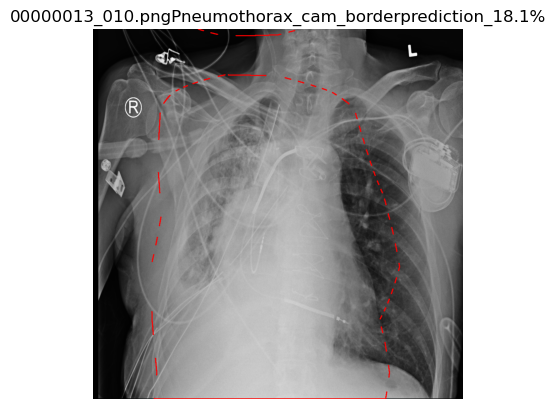

In [15]:
sample_path = "/Users/jiashuoli/Desktop/thesis/NIH/sample_full/"
output_path = "/Users/jiashuoli/Desktop/thesis/NIH/output/"
# for all the images in the sample folder, we need to resize the cam to the same size as the original image
# and then overlay the cam on the original image

# for each image in the sample folder
for nameIndex in os.listdir(sample_path):
    #First we create a new folder for each image
    folder_path = output_path + nameIndex 
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    
    
    sample_img = skimage.io.imread(sample_path+nameIndex,as_gray=True)
    print("Original image size: "+str(sample_img.shape))
    #  create new empty RGB channel array
    img_rgb11 = grey2rgb(sample_img)
    
    # prepare the image
    resize_img = xrv.datasets.normalize(sample_img, 1025) 
    # resize the image to 224*224
    transform = torchvision.transforms.Compose([xrv.datasets.XRayResizer(224)])
    img_transform = transform(resize_img)
    img_torch = torch.from_numpy(img_transform)
    print("Model input size: "+str(img_torch.shape))
    # feed the image to the model
    outputs = model(img_torch.unsqueeze(0)) # or model.features(img[None,...]) 
    print((map_predictions(outputs.squeeze().detach().numpy())))
    pred = outputs.squeeze().detach().numpy()
    
    # we have 18 predictions for each image, for each prediction, we have a cam
    cam_list = []
    #generate a list of 18 index
    index_list = list(range(18))
    for i in index_list:
        temp_extractor = LayerCAM(model = model,target_layer=model.features.denseblock4,input_shape=(1,224,224))
        outputs = model(img_torch.unsqueeze(0))
        cam_result = temp_extractor(i, outputs)
        cam_list.append(cam_result)
        for cam in cam_result:
            #print(cam.shape)
            cam_resized = resize(cam.squeeze(), (1024,1024))
            #print(cam_resized)
            
            # overlay the original heatmap on the original image
            title = nameIndex+labels[i]+"_cam_jet"+"prediction_"+"{:.1f}".format(pred[i]*100) + "%"
            original_overlay = overlay_mask(to_pil_image(img_rgb11),to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5, colormap='jet')
            plt.imshow(original_overlay); plt.axis('off'); plt.title(title)
            # plt.show()
            #save the image
            plt.savefig(folder_path+"/"+title+".png")

            # overlay the original heatmap on the original image but with different colormap
            title = nameIndex+labels[i]+"_cam_OrRd"+"prediction_"+"{:.1f}".format(pred[i]*100) + "%"
            original_overlay = overlay_mask(to_pil_image(img_rgb11),to_pil_image(cam.squeeze(0), mode='F'), alpha=0.5, colormap='OrRd')
            plt.imshow(original_overlay); plt.axis('off'); plt.title(title)
            # plt.show()
            #save the image
            plt.savefig(folder_path+"/"+title+".png")
            
            #use otsu's method to threshold the cam
            cam_otsu = otsu_process(cam_resized)
            title = nameIndex+labels[i]+"_cam_Otsu"+"prediction_"+"{:.1f}".format(pred[i]*100) + "%"
            otsu_overlay = overlay_mask_on_image(img_rgb11,cam_otsu, alpha=0.5, color=(255, 0, 0))
            plt.imshow(otsu_overlay); plt.axis('off'); plt.title(title)
            # plt.show()
            #save the image
            plt.savefig(folder_path+"/"+title+".png")
            
            #generate the outline of the cam and overlay it on the original image
                        
            cam_border = overlay_dashed_border_on_image(img_rgb11,cam_otsu, color=(255, 0, 0), dash_length=10)
            title = nameIndex+labels[i]+"_cam_border"+"prediction_"+"{:.1f}".format(pred[i]*100) + "%"
            plt.imshow(cam_border); plt.axis('off'); plt.title(title)
            # plt.show()
            #save the image
            plt.savefig(folder_path+"/"+title+".png")
            




## Method 1: Original CAM Heatmap

In [10]:
# read png picture

sample_path = "/Users/jiashuoli/Desktop/thesis/NIH/sample_full3/"

# for all the images in the sample folder, we need to resize the cam to the same size as the original image
# and then overlay the cam on the original image

# for each image in the sample folder
for nameIndex in os.listdir(sample_path):
    sample_img = skimage.io.imread(sample_path+nameIndex,as_gray=True)
    print(sample_img.shape)
        #  create new empty RGB channel array
    img_rgb11 = np.zeros((*sample_img.shape, 3), dtype=np.uint8)

    for i in range(3):
        img_rgb11[..., i] = sample_img


(1024, 1024)
